In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

Epoch [1/15000], Loss: 15.7198553085, MSE: 3.0583524704
Epoch [101/15000], Loss: 12.5096454620, MSE: 3.0018277168
Epoch [201/15000], Loss: 10.4444370270, MSE: 3.0182082653
Epoch [301/15000], Loss: 9.2017936707, MSE: 3.0592799187
Epoch [401/15000], Loss: 8.4679641724, MSE: 3.0808711052
Epoch [501/15000], Loss: 7.9610929489, MSE: 3.0640919209
Epoch [601/15000], Loss: 7.5069508553, MSE: 3.0014925003
Epoch [701/15000], Loss: 6.9852542877, MSE: 2.8816688061
Epoch [801/15000], Loss: 6.3029017448, MSE: 2.6858239174
Epoch [901/15000], Loss: 5.4413113594, MSE: 2.4060697556
Epoch [1001/15000], Loss: 4.5110974312, MSE: 2.0710918903
Epoch [1101/15000], Loss: 3.6440145969, MSE: 1.7377656698
Epoch [1201/15000], Loss: 2.8386406898, MSE: 1.4428113699
Epoch [1301/15000], Loss: 2.0862624645, MSE: 1.1760379076
Epoch [1401/15000], Loss: 1.5077816248, MSE: 0.9438875318
Epoch [1501/15000], Loss: 1.1558111906, MSE: 0.7701466084
Epoch [1601/15000], Loss: 0.9492893219, MSE: 0.6435027122
Epoch [1701/15000], Los

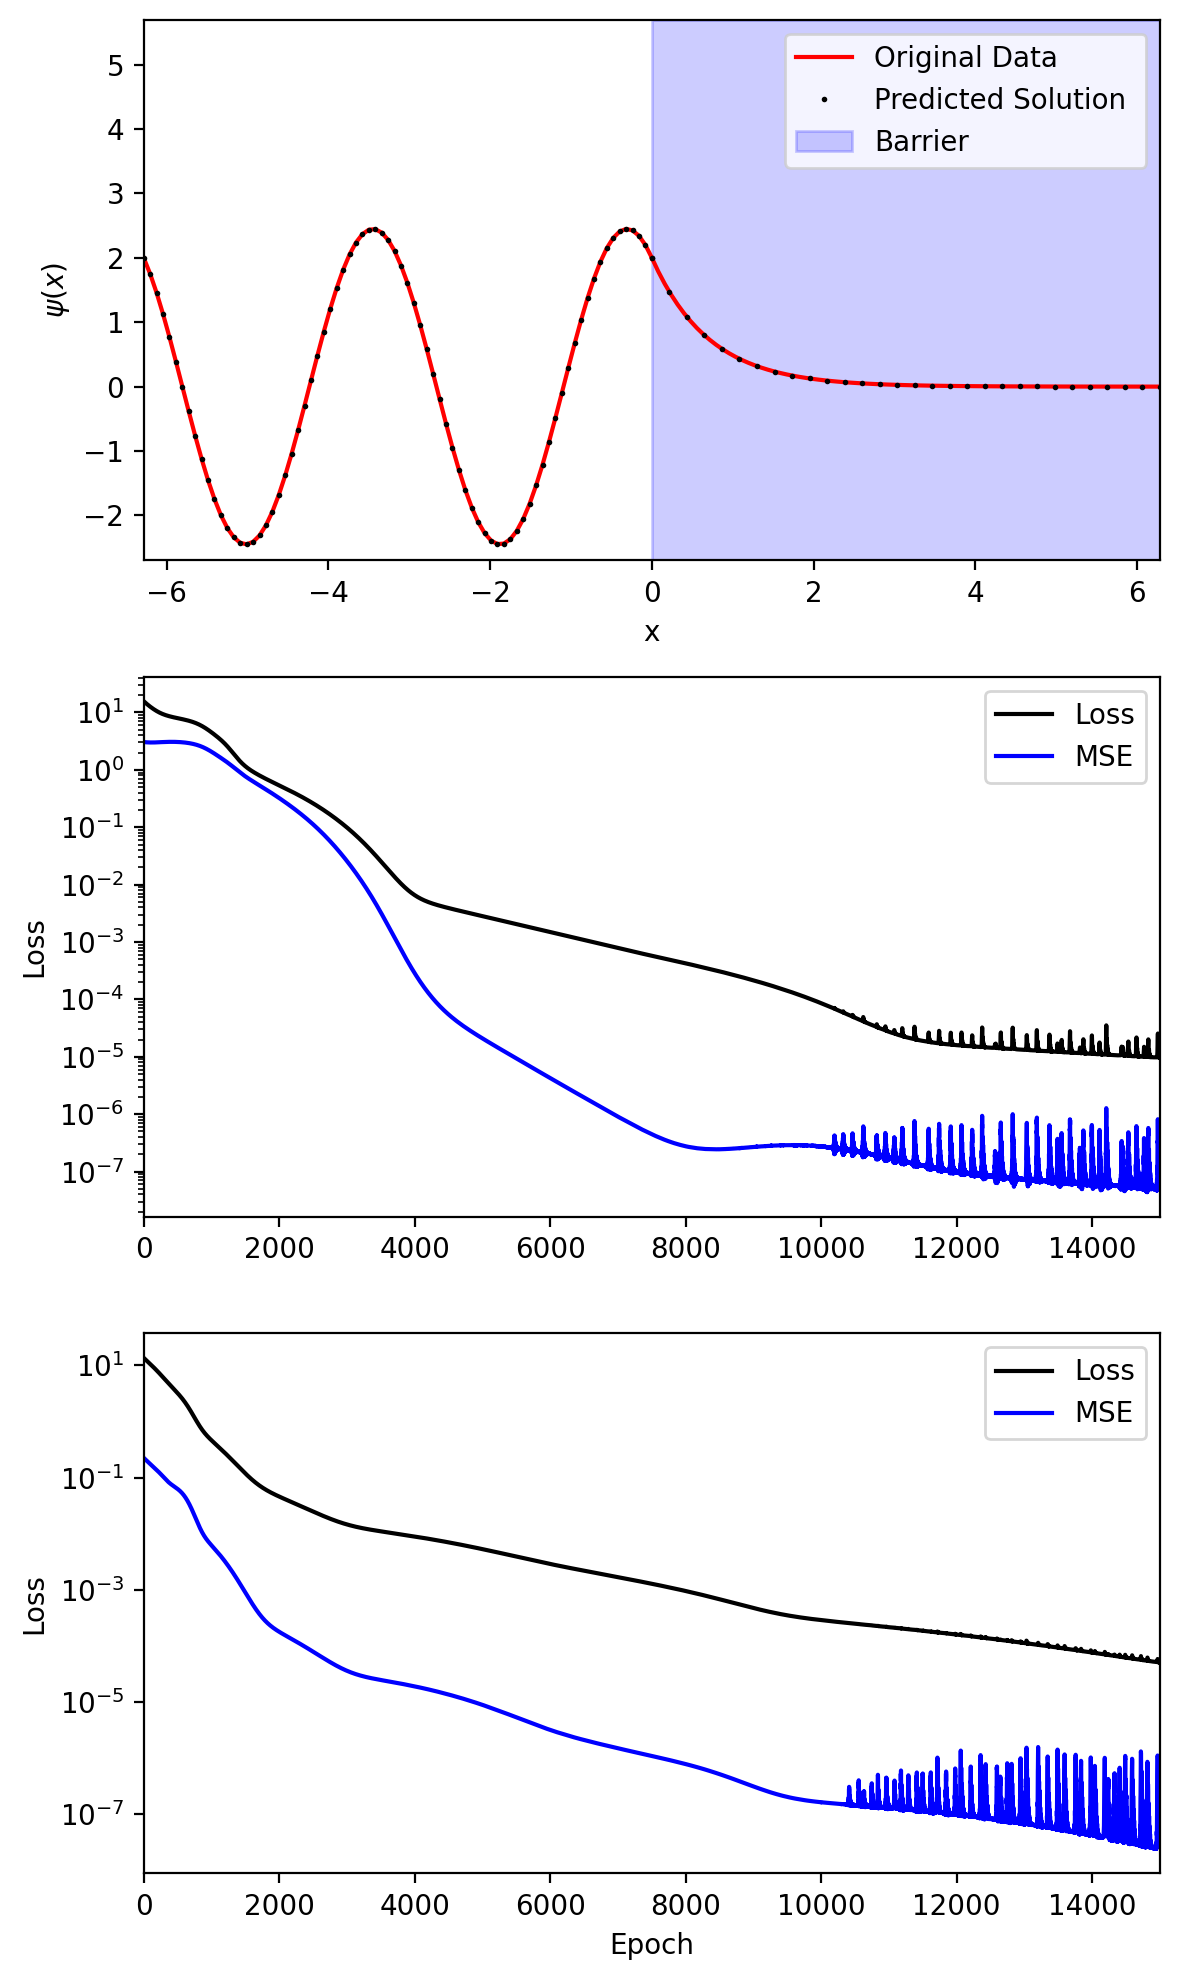

In [10]:
# potencial degrau
# métrica > MSE
# função de perda: > Loss_function_total
# otimizado: ADAM

m = 1
h = 1
E = 2
V = 3
D = 2
L1 = -2*np.pi
L2 =  2*np.pi
k_um = np.sqrt(2 * m * E) / h
k_dois = np.sqrt(2 * m * (V - E))/h


class OdeSecond(nn.Module):
    def __init__(self):
        super(OdeSecond, self).__init__()
        self.dense1 = nn.Linear(1, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.sin(self.dense1(x))
        x = torch.sin(self.dense2(x))
        return self.dense3(x)

def train_step_ONE(model, optimizer, loss_fn, x_train, y_train, L, k):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([[L1]], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([[D]], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([[-D*k_dois]], dtype=torch.float32)

    xL = torch.tensor([[0]], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([[D]], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
        loss_fn(y0_NN, y0_exact)
        +loss_fn(d2y_dx2_NN,  - y_NN * (k_um ** 2))
        +loss_fn(dy_dx0_NN, dy_dx0_exact)
        +loss_fn(yL_NN, yL_exact) )

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()

def train_step_TWO(model, optimizer, loss_fn, x_train, y_train, L, k):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    optimizer.zero_grad()

    x0 = torch.tensor([[0]], dtype=torch.float32, requires_grad=True)
    y0_exact = torch.tensor([[D]], dtype=torch.float32)
    dy_dx0_exact = torch.tensor([[-D*k_dois]], dtype=torch.float32)

    xL = torch.tensor([[L2]], dtype=torch.float32, requires_grad=True)
    yL_exact = torch.tensor([[D * np.exp(-k_dois * L2)]], dtype=torch.float32)

    y0_NN = model(x0)
    dy_dx0_NN = torch.autograd.grad(y0_NN.sum(), x0, create_graph=True)[0]
    yL_NN = model(xL)

    y_NN = model(x_train_tensor)
    dy_dx_NN = torch.autograd.grad(y_NN.sum(), x_train_tensor, create_graph=True)[0]
    d2y_dx2_NN = torch.autograd.grad(dy_dx_NN.sum(), x_train_tensor, create_graph=True)[0]

    loss = (
            loss_fn(y0_NN, y0_exact)
            +loss_fn(d2y_dx2_NN, y_NN * (k_dois**2))
            +loss_fn(dy_dx0_NN,  dy_dx0_exact)
            +loss_fn(yL_NN,  yL_exact) )

    loss.backward()
    optimizer.step()

    mse = nn.MSELoss()(y_NN, y_train_tensor)
    return loss.item(), mse.item()

def plot_combined_solution(model1, model2, x_train1, y_train1, x_train2, y_train2, mse_values_1, loss_values_1, mse_values_2, loss_values_2):
    model1.eval()
    model2.eval()

    x_test_tensor_1 = torch.linspace(L1, 0, 80).unsqueeze(1)
    x_test_tensor_2 = torch.linspace(0, L2, 30).unsqueeze(1)

    with torch.no_grad():
        y_pred_1 = model1(x_test_tensor_1)
        y_pred_2 = model2(x_test_tensor_2)

        # Combinação das previsões e dos domínios
        y_combined_pred = torch.cat((y_pred_1, y_pred_2), dim=0)
        x_combined = torch.cat((x_test_tensor_1, x_test_tensor_2), dim=0)
        y_combined_train = torch.cat((torch.tensor(y_train1), torch.tensor(y_train2)), dim=0)


    # Gráfico da solução prevista pela rede
    fig, ax = plt.subplots(3, 1, figsize=(6, 10))
    plt.rcParams['figure.dpi'] = 200
    ax[0].plot(x_train1, y_train1, markersize=5, color='red', label='Original Data ')
    ax[0].plot(x_test_tensor_1.numpy(), y_pred_1.numpy(), '.', markersize=2, color='black', label='Predicted Solution ')
    ax[0].plot(x_train2, y_train2, markersize=5, color='red')
    ax[0].legend(fontsize=5)
    ax[0].plot(x_test_tensor_2.numpy(), y_pred_2.numpy(), '.', markersize=2, color='black')
    ax[0].set_xlabel('x')
    ax[0].set_xlim(L1, L2)
    ax[0].set_ylabel(r'$\psi(x)$')

    ymin, ymax = ax[0].get_ylim()
    new_ymax = ymax + 3
    ax[0].set_ylim(ymin, new_ymax)
    x_0, x_a = 0, L2
    ymin, ymax = ax[0].get_ylim()
    ax[0].axvspan(x_0, x_a, color='blue', alpha=0.2, label='Barrier')
    ax[0].legend()


    # Segundo subplot = loss e mse
    loss_values =  loss_values_1
    mse_values =  mse_values_1
    ax[1].set_yscale('log')
    ax[1].plot(loss_values, color='black', label='Loss')
    ax[1].set_xlim(0, 15000)
    ax[1].plot(mse_values, color='blue', label='MSE')
    ax[1].set_ylabel(r'Loss')
    #ax[1].text(0.1, 0.1, 'Região I', transform=ax[1].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5), ha='center')
    ax[1].legend()


    loss_values2 =  loss_values_2
    mse_values2 =  mse_values_2
    ax[2].set_yscale('log')
    ax[2].plot(loss_values2, color='black', label='Loss')
    ax[2].plot(mse_values2, color='blue', label='MSE')
    ax[2].set_xlim(0, 15000)
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel(r'Loss')
    #ax[2].text(0.1, 0.1, 'Região II', transform=ax[2].transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5), ha='center')
    ax[2].legend()
    # Terceiro subplot = histograma

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Treinamento para x <= 0
    x_train1 = np.linspace(L1, 0, 80)[:, np.newaxis]
    y_train1 = D * (np.cos(k_um * x_train1) - (k_dois / k_um) * np.sin(k_um * x_train1))
    model1 = OdeSecond()
    optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
    loss_fn = nn.MSELoss()
    loss_values_1 = []
    mse_values_1 = []

    epochs = 15000
    for epoch in range(epochs):
        loss, mse = train_step_ONE(model1, optimizer1, loss_fn, x_train1, y_train1, L1, k_um)
        loss_values_1.append(loss)
        mse_values_1.append(mse)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.10f}, MSE: {mse:.10f}")


    # Treinamento para x >= 0
    x_train2 = np.linspace(0, L2, 80)[:, np.newaxis]
    y_train2 = D * np.exp(-k_dois * x_train2)
    model2 = OdeSecond()
    optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
    loss_values_2 = []
    mse_values_2 = []

    for epoch in range(epochs):
        loss, mse = train_step_TWO(model2, optimizer2, loss_fn, x_train2, y_train2, L2, k_dois)
        loss_values_2.append(loss)
        mse_values_2.append(mse)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss:.10f}, MSE: {mse:.10f}")


    # Plotando ambas as soluções
    plot_combined_solution(model1, model2, x_train1, y_train1, x_train2, y_train2, mse_values_1, loss_values_1, mse_values_2, loss_values_2)